# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
#Disable gpu and enable cpu only
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import sys
sys.path.insert(0,'../python_kmeans_dominant_colors')
sys.path.insert(0,'../color-describer')
from color_kmeans import dominant_colors
import colordesc

import random
import math
import numpy as np
import scipy.misc
import matplotlib
import matplotlib.pyplot as plt
import cv2

import coco
import utils
import model as modellib
import visualize

import pickle
from tqdm import tqdm
import operator
from scipy.stats import entropy

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to trained weights file
# Download this file and place in the root of your 
# project (See README file for details)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.7 or higher required)
NoneType: None
Using TensorFlow backend.


In [2]:
describer = colordesc.ColorDescriber()
describer.describe((255, 0, 0))

'red'

In [3]:
def show_image(image):
    height = image.shape[0]
    width = image.shape[1]
    
    margin=50 # pixels
    dpi=100. # dots per inch

    figsize=((width+2*margin)/dpi, (height+2*margin)/dpi) # inches
    left = margin/dpi/figsize[0] #axes ratio
    bottom = margin/dpi/figsize[1]

    fig = plt.figure(figsize=figsize, dpi=dpi)
    fig.subplots_adjust(left=left, bottom=bottom, right=1.-left, top=1.-bottom)

    plt.imshow(image)
    plt.show()

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.print()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

## Create Model and Load Trained Weights

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [7]:
with open('../refer/my_refer_data.pickle', 'rb') as file:
    my_refer_data = pickle.load(file)

In [8]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou

## Run Object Detection

  0%|          | 0/33945 [00:00<?, ?it/s]

shirt - person
max_iou: 0.954719921175
sentence: blue shirt


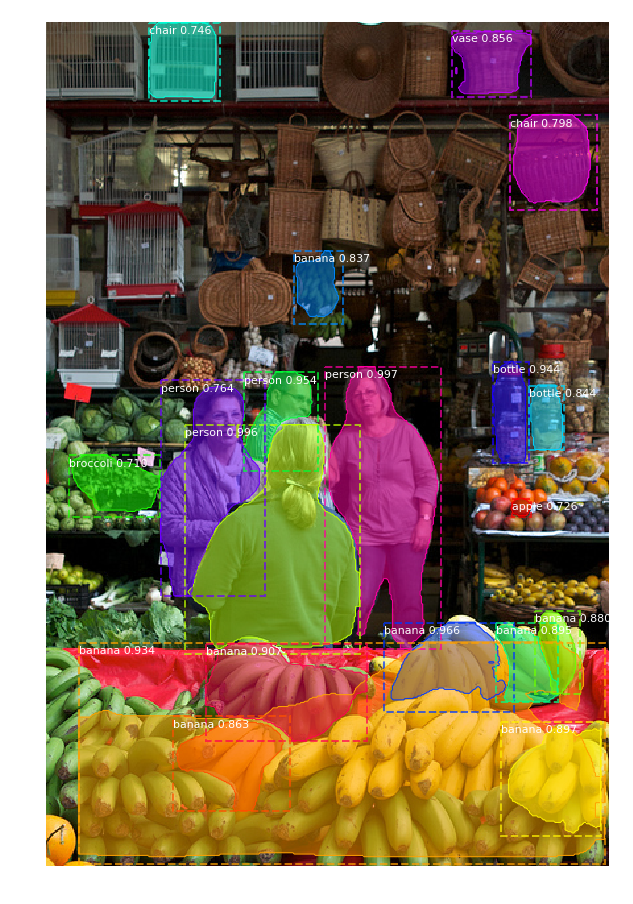

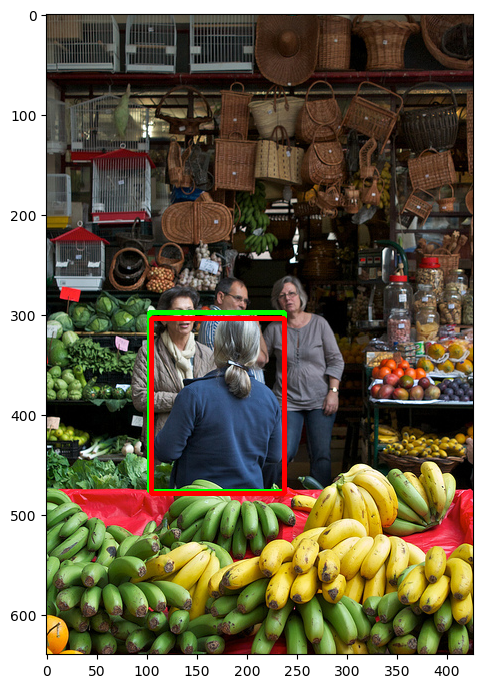

In [20]:
pairs = dict()

with open('../refer/train_ref_ids.pickle', 'rb') as file:
    train_ref_ids = pickle.load(file)
train_ref_ids = set(train_ref_ids)
my_train_ref_ids = list(train_ref_ids & set(my_refer_data['ref_ids']))
    
for ref_id in tqdm(my_train_ref_ids):
    
    x,y,w,h = my_refer_data['boxes'][ref_id]
    x1,y1,x2,y2 = x,y,x+w,y+h
    
    # Load a random image from the images folder
    #file_names = next(os.walk(IMAGE_DIR))[2]
    #image = scipy.misc.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
    image = scipy.misc.imread(my_refer_data['image_file_names'][ref_id])
    if len(image.shape) != 3:
        continue
    
    # Run detection
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])
    
    class_ids = results[0]['class_ids']
    boxes = results[0]['rois']
    if len(boxes) == 0:
        continue
    
    box = boxes[0]
    bx1,by1,bx2,by2 = box[1],box[0],box[3],box[2]
    max_iou = bb_intersection_over_union((x1,y1,x2,y2), (bx1,by1,bx2,by2))
    
    max_iou_box_index = 0
    max_iou_box = bx1,by1,bx2,by2
    
    for i, box in enumerate(boxes):
        bx1,by1,bx2,by2 = box[1],box[0],box[3],box[2]
        iou = bb_intersection_over_union((x1,y1,x2,y2), (bx1,by1,bx2,by2))
        if iou > max_iou:
            max_iou = iou
            max_iou_box_index = i
            max_iou_box = bx1,by1,bx2,by2
    
    refer_subject = my_refer_data['subjects'][ref_id]
    mask_rcnn_class = class_names[class_ids[max_iou_box_index]]
    
    print(my_refer_data['subjects'][ref_id], '-', class_names[class_ids[max_iou_box_index]])
    
#     if refer_subject not in pairs:
#         pairs[refer_subject] = dict()
#     pair = pairs[refer_subject]
#     if mask_rcnn_class in pair:
#         pair[mask_rcnn_class] += 1
#     else:
#         pair[mask_rcnn_class] = 1
    
    image = scipy.misc.imread(my_refer_data['image_file_names'][ref_id])
    cv2.rectangle(image,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),3)
    cv2.rectangle(image,(max_iou_box[0],max_iou_box[1]),(max_iou_box[2],max_iou_box[3]),(255,0,0),3)
    
    print('max_iou:',max_iou)
    print('sentence:', my_refer_data['sentences'][ref_id])
    show_image(image)
    
    break
    

In [61]:
with open('pairs.pickle', 'wb') as file:
    pickle.dump(pairs, file)

In [22]:
with open('pairs.pickle', 'rb') as file:
    pairs = pickle.load(file)

In [23]:
pairs

{'shirt': {'chair': 1,
  'couch': 1,
  'cup': 1,
  'dining table': 5,
  'dog': 1,
  'fork': 1,
  'keyboard': 1,
  'motorcycle': 1,
  'person': 1421,
  'teddy bear': 3,
  'umbrella': 1},
 'woman': {'bed': 1,
  'chair': 2,
  'couch': 2,
  'elephant': 1,
  'handbag': 1,
  'horse': 1,
  'person': 1350},
 'standing': {'banana': 1,
  'bicycle': 1,
  'bird': 1,
  'book': 1,
  'elephant': 3,
  'giraffe': 1,
  'person': 20,
  'sheep': 1,
  'suitcase': 3,
  'teddy bear': 1,
  'zebra': 1},
 'person': {'bed': 1,
  'bench': 1,
  'bicycle': 1,
  'bottle': 1,
  'bowl': 1,
  'car': 1,
  'cat': 1,
  'cell phone': 1,
  'chair': 4,
  'couch': 2,
  'dining table': 5,
  'dog': 1,
  'elephant': 1,
  'giraffe': 1,
  'handbag': 1,
  'motorcycle': 1,
  'person': 2048,
  'remote': 1,
  'teddy bear': 2,
  'tennis racket': 1,
  'toilet': 1,
  'truck': 1,
  'tv': 1},
 'vase': {'bottle': 8,
  'chair': 1,
  'cup': 1,
  'dining table': 3,
  'person': 1,
  'potted plant': 15,
  'vase': 156},
 'bus': {'boat': 1,
  'bus

In [50]:
subject_labels_sorted = dict()

for pair in pairs:
    labels = pairs[pair]
    labels = [(key, labels[key]) for key in labels]
    labels.sort(key=operator.itemgetter(1), reverse=True)
    subject_labels_sorted[pair] = labels
    
with open('subject_labels_sorted.pickle', 'wb') as file:
    pickle.dump(subject_labels_sorted, file)

In [92]:
best_pairs = dict()
best_pair_counts = list()
for subject in pairs:
    best_pairs[subject] = max(pairs[subject].items(), key=operator.itemgetter(1))[0]
    best_pair_count = pairs[subject][best_pairs[subject]]
    best_pair_counts.append(((subject, best_pairs[subject]), best_pair_count))

In [93]:
best_pair_counts.sort(key=operator.itemgetter(1), reverse=True)

Populating the interactive namespace from numpy and matplotlib


[]

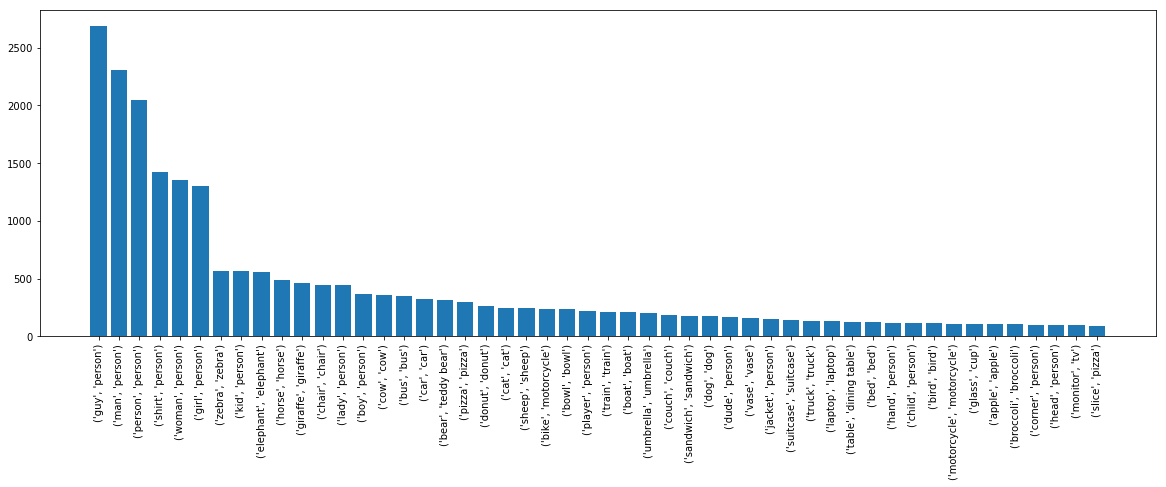

In [120]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

best_pairs, counts = zip(*best_pair_counts[:50])
x_pos = np.arange(len(best_pairs[:50]))

plt.bar(x_pos, counts,align='center')
plt.xticks(x_pos, best_pairs, rotation='vertical') 
plt.plot()

In [33]:
entropies = list()

for pair in pairs:
    labels = pairs[pair]
    freqs = list(labels[key] for key in labels.keys())
    count = sum(freqs)
    entropies.append((pair, entropy(freqs,base=2)))

In [35]:
pairs['food']

{'book': 1,
 'bottle': 1,
 'bowl': 43,
 'broccoli': 4,
 'bus': 2,
 'cake': 3,
 'carrot': 3,
 'dining table': 37,
 'donut': 12,
 'hot dog': 1,
 'pizza': 38,
 'sandwich': 20,
 'truck': 1}

In [25]:
high_uncertainty = entropy([6,4],base=2)

In [26]:
high_uncertainty

0.9709505944546688

In [38]:
print('no. of high uncertainty:', sum(1 for subject_entropy in entropies if subject_entropy[1] >= high_uncertainty))

no. of high uncertainty: 340


In [165]:
print('no. of subjects:',len(entropies))

no. of subjects: 1784


In [169]:
340/1784

0.1905829596412556

In [181]:
#save labels per images:

with open('../refer/train_ref_ids.pickle', 'rb') as file:
    train_ref_ids = pickle.load(file)
train_ref_ids = set(train_ref_ids)
my_train_ref_ids = list(train_ref_ids & set(my_refer_data['ref_ids']))

labels_per_images = dict()

for ref_id in tqdm(my_train_ref_ids):
    
    # Load a random image from the images folder
    #file_names = next(os.walk(IMAGE_DIR))[2]
    #image = scipy.misc.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
    image_path = my_refer_data['image_file_names'][ref_id]
    if image_path in labels_per_images:
        continue
    image = scipy.misc.imread(my_refer_data['image_file_names'][ref_id])
    if len(image.shape) != 3:
        continue
    
    # Run detection
    results = model.detect([image], verbose=1)
    class_ids = results[0]['class_ids']
    labels_per_images[image_path] = class_ids

100%|██████████| 33945/33945 [2:42:37<00:00,  3.48it/s]  


In [182]:
# with open('labels_per_images.pickle', 'wb') as file:
#     pickle.dump(labels_per_images, file)

In [7]:
import numpy as np
import pickle
import statistics

with open('labels_per_images.pickle', 'rb') as file:
    labels_per_images = pickle.load(file)

In [4]:
number_of_labels = list()
for image_path in labels_per_images:
    number_of_labels.append(len(labels_per_images[image_path]))

In [8]:


print('min:', min(number_of_labels), 
      'max:', max(number_of_labels), 
      'avg:', sum(number_of_labels)/len(number_of_labels),
      'std:', statistics.stdev(number_of_labels))

min: 0 max: 100 avg: 9.281884750079593 std: 6.905911479332715


# Baseline

In [9]:
with open('../refer/val_ref_ids.pickle', 'rb') as file:
    val_ref_ids = pickle.load(file)
    
with open('../refer/filter_keywords.pickle', 'rb') as file:
    filter_keywords = pickle.load(file)
filter_keywords = set(filter_keywords)
    
with open('subject_labels_sorted.pickle', 'rb') as file:
    subject_labels_sorted = pickle.load(file)

  0%|          | 0/3070 [00:00<?, ?it/s]

['oven', 'microwave', 'cup', 'refrigerator', 'bottle', 'bowl', 'bottle', 'cup', 'cup', 'traffic light', 'bowl', 'bottle', 'cup']
[('refrigerator', 31), ('person', 3)]
refrigerator
480 640
subject: fridge
sentence: the fridge on the left behind the wire shelf


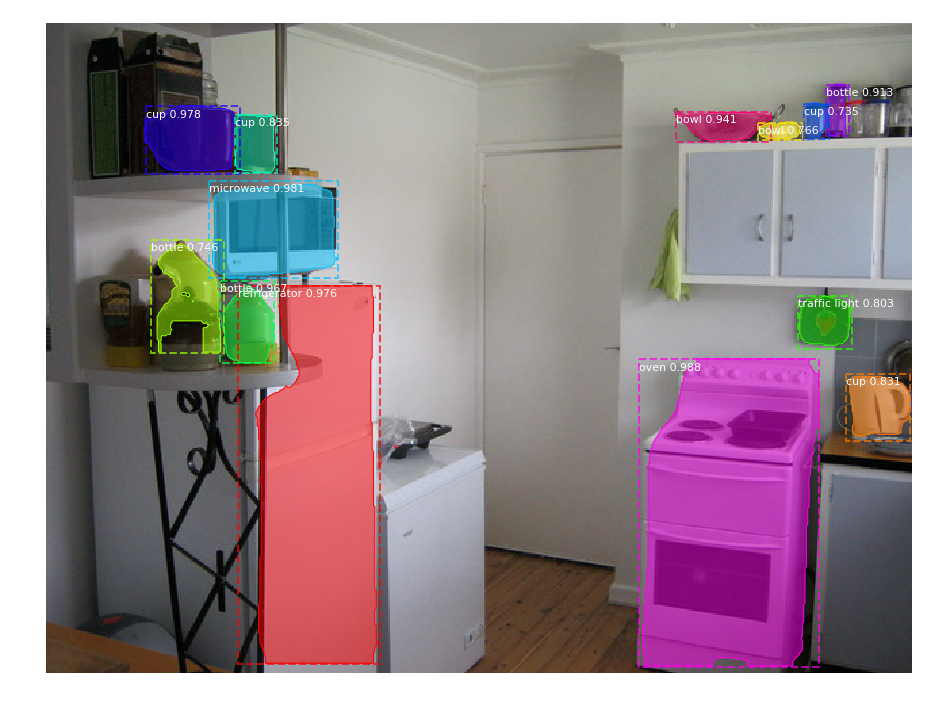

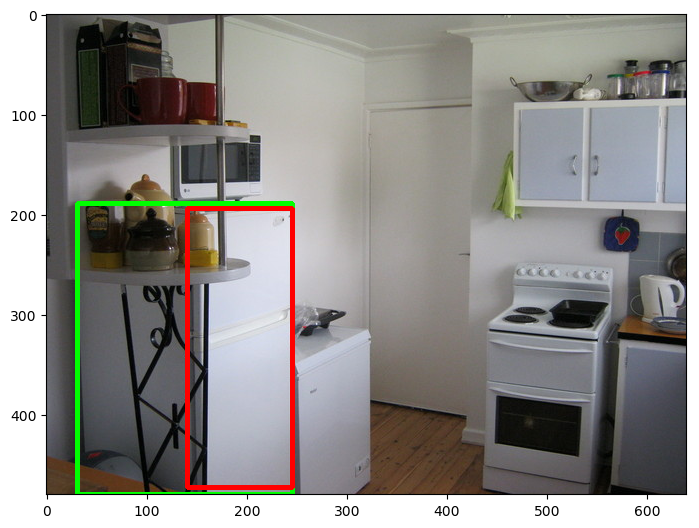

0.47248380481


In [19]:
val_ref_ids = set(val_ref_ids)
my_val_ref_ids = list(val_ref_ids & set(my_refer_data['ref_ids']))
    
for ref_id in tqdm(my_val_ref_ids[20:]):
    
    x,y,w,h = my_refer_data['boxes'][ref_id]
    x1,y1,x2,y2 = x,y,x+w,y+h
    
    # Load a random image from the images folder
    #file_names = next(os.walk(IMAGE_DIR))[2]
    #image = scipy.misc.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
    image = scipy.misc.imread(my_refer_data['image_file_names'][ref_id])
    if len(image.shape) != 3:
        continue
    
    # Run detection
    results = model.detect([image], verbose=1)

    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])
    
    class_ids = results[0]['class_ids']
    boxes = results[0]['rois']
    if len(boxes) == 0:
        continue
        
    current_class_names = [class_names[id] for id in class_ids]
    print(current_class_names)
    
    refer_subject = my_refer_data['subjects'][ref_id]
    
    current_subject_labels = subject_labels_sorted[refer_subject]
    print(current_subject_labels)
    found_label = None
    for subject_label in current_subject_labels:
        if subject_label[0] in current_class_names:
            found_label = subject_label[0]
            break
    print(found_label)
    
    image = scipy.misc.imread(my_refer_data['image_file_names'][ref_id])
    height, width, _ = image.shape
    print(height,width)
    
    best_i = -1
    best_box = None
    for i, class_name in enumerate(current_class_names):
        if class_name == found_label:
            box = boxes[i]
            bx1,by1,bx2,by2 = box[1],box[0],box[3],box[2]
            
            tokens = my_refer_data['sentences'][ref_id].split(' ')
            current_filter_keywords = list(set(tokens) & filter_keywords)
            keyword = current_filter_keywords[0]
            if best_i == -1:
                best_i = i
                best_box = bx1,by1,bx2,by2
            elif keyword == 'left':
                if (bx1+bx2)/2 < (best_box[0]+best_box[2])/2:
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            elif keyword == 'right':
                if (bx1+bx2)/2 > (best_box[0]+best_box[2])/2:
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            elif keyword == 'bottom':
                if (by1+by2)/2 > (best_box[1]+best_box[3])/2:
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            elif keyword == 'top':
                if (by1+by2)/2 < (best_box[1]+best_box[3])/2:
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            elif keyword == 'middle':
                if abs((bx1+bx2)/2-width/2) < abs((best_box[0]+best_box[2])/2-width/2):
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            elif keyword == 'big' or keyword == 'huge':
                if (bx2-bx1)*(by2-by1)>(best_box[2]-best_box[0])*(best_box[3]-best_box[1]):
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            elif keyword == 'small' or keyword == 'tiny':
                if (bx2-bx1)*(by2-by1)<(best_box[2]-best_box[0])*(best_box[3]-best_box[1]):
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            elif keyword == 'long' or keyword == 'tall':
                if (by2-by1)>(best_box[3]-best_box[1]):
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            elif keyword == 'short':
                if (by2-by1)<(best_box[3]-best_box[1]):
                    best_i = i
                    best_box = bx1,by1,bx2,by2
            else: #color
                original_mask = r['masks'][:,:,1]
                mask = np.zeros(image.shape, dtype=np.uint8)
                for i in range(mask.shape[0]):
                    for j in range(mask.shape[1]):
                        mask[i,j] = original_mask[i,j]

                masked_image = np.multiply(mask,image)
                show_image(masked_image)
                recognized_colors = dominant_colors(masked_image, 5)
                for recognized_color in recognized_colors:
                    if keyword == describer.describe(recognized_color):
                        best_i = i
                        best_box = bx1,by1,bx2,by2
                        break
            if best_i != -1:
                break
    print('subject:', my_refer_data['subjects'][ref_id])
    
    
    cv2.rectangle(image,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),3)
    cv2.rectangle(image,(best_box[0],best_box[1]),(best_box[2],best_box[3]),(255,0,0),3)
    
    print('sentence:', my_refer_data['sentences'][ref_id])
    show_image(image)
    print(bb_intersection_over_union((x1,y1,x2,y2),best_box))
    
    break

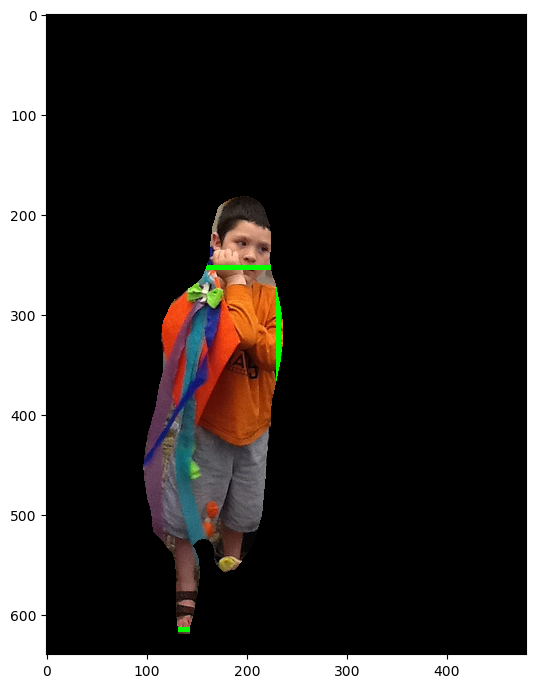

orange
grey
brown
brown
green


In [12]:
original_mask = r['masks'][:,:,1]
mask = np.zeros(image.shape, dtype=np.uint8)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        mask[i,j] = original_mask[i,j]

masked_image = np.multiply(mask,image)
show_image(masked_image)
recognized_colors = dominant_colors(masked_image, 5)
for recognized_color in recognized_colors:
    print(describer.describe(recognized_color))